# Question 4

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_rbf_layer (CustomRBFLayer)    │ (None, 50)                  │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 451 (1.76 KB)

 Trainable params: 451 (1.76 KB)

 Non-trainable params: 0 (0.00 B)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4265 - mae: 0.4720
RBF Network - Loss: 0.4319261610507965, MAE: 0.471592515707016


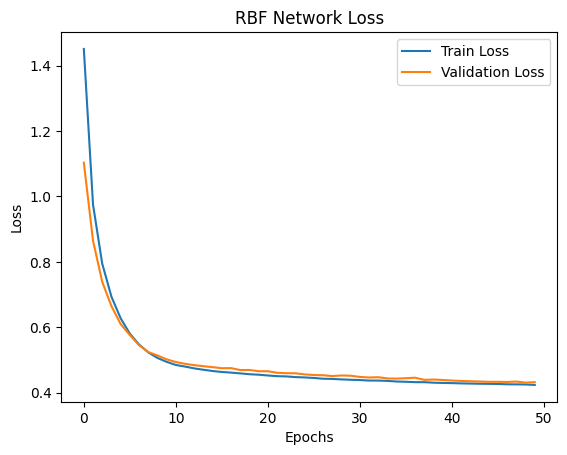

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2643 - mae: 0.3540
Dense Network - Loss: 0.270912766456604, MAE: 0.3544943034648895


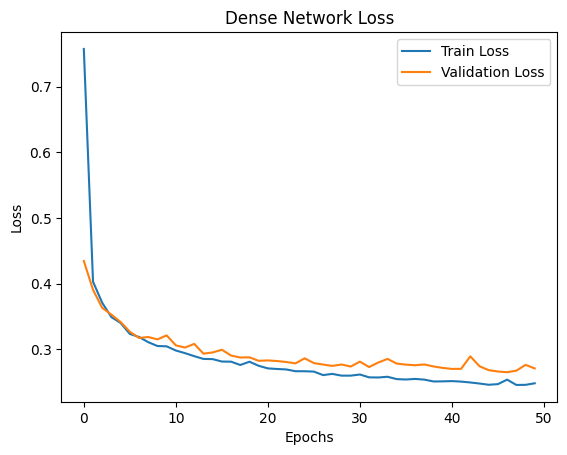

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Layer, Input, Dense
from tensorflow.keras.models import Model

data_set = fetch_california_housing()
X_data = data_set.data
y_data = data_set.target

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

scaler_obj = StandardScaler()
X_train_data = scaler_obj.fit_transform(X_train_data)
X_test_data = scaler_obj.transform(X_test_data)

y_train_data = y_train_data.reshape(-1, 1)
y_test_data = y_test_data.reshape(-1, 1)

class CustomRBFLayer(Layer):
    def __init__(self, units, gamma_value, **kwargs):
        super(CustomRBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma_value = tf.constant(gamma_value, dtype=tf.float32)

    def build(self, input_shape):
        self.center_weights = self.add_weight(
            name='center_weights',
            shape=(self.units, input_shape[-1]),
            initializer='random_uniform',
            trainable=True
        )
        super(CustomRBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff_matrix = tf.expand_dims(inputs, axis=1) - self.center_weights
        l2_norm = tf.reduce_sum(tf.square(diff_matrix), axis=-1)
        return tf.exp(-self.gamma_value * l2_norm)

num_features = X_train_data.shape[1]
num_centers = 50
gamma_value = 0.1

input_layer = Input(shape=(num_features,))
rbf_layer = CustomRBFLayer(units=num_centers, gamma_value=gamma_value)(input_layer)
output_layer = Dense(1, activation='linear')(rbf_layer)
rbf_net = Model(inputs=input_layer, outputs=output_layer)

rbf_net.compile(optimizer='adam', loss='mse', metrics=['mae'])

rbf_net.summary()

# Train
history_rbf_net = rbf_net.fit(X_train_data, y_train_data, validation_data=(X_test_data, y_test_data),
                              epochs=50, batch_size=32, verbose=0)

# Evaluation
loss_rbf_net, mae_rbf_net = rbf_net.evaluate(X_test_data, y_test_data)
print(f"RBF Network - Loss: {loss_rbf_net}, MAE: {mae_rbf_net}")

import matplotlib.pyplot as plt

plt.plot(history_rbf_net.history['loss'], label='Train Loss')
plt.plot(history_rbf_net.history['val_loss'], label='Validation Loss')
plt.title('RBF Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

input_layer_dense = Input(shape=(num_features,))
dense_hidden_layer1 = Dense(64, activation='relu')(input_layer_dense)
dense_hidden_layer2 = Dense(32, activation='relu')(dense_hidden_layer1)
output_layer_dense = Dense(1, activation='linear')(dense_hidden_layer2)

dense_net = Model(inputs=input_layer_dense, outputs=output_layer_dense)

dense_net.compile(optimizer='adam', loss='mse', metrics=['mae'])

dense_net.summary()

history_dense_net = dense_net.fit(X_train_data, y_train_data, validation_data=(X_test_data, y_test_data),
                                  epochs=50, batch_size=32, verbose=0)

loss_dense_net, mae_dense_net = dense_net.evaluate(X_test_data, y_test_data)
print(f"Dense Network - Loss: {loss_dense_net}, MAE: {mae_dense_net}")

plt.plot(history_dense_net.history['loss'], label='Train Loss')
plt.plot(history_dense_net.history['val_loss'], label='Validation Loss')
plt.title('Dense Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
